In [1]:
import numpy as np
import pprint
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.gridworld import GridworldEnv
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

In [3]:
def plot_policy(ax, policy):
    x_range = np.arange(0, env.shape[0], 1) + 0.5
    y_range = np.arange(0, env.shape[1], 1) + 0.5
    X, Y = np.meshgrid(x_range, y_range)

    X_dir = np.zeros(X.shape)
    Y_dir = np.zeros(Y.shape)
    Left_dir = -1 * np.copy(policy[:,3]).reshape(X_dir.shape)
    Right_dir = np.copy(policy[:,1]).reshape(X_dir.shape)
    Up_dir = -1 * np.copy(policy[:,0]).reshape(X_dir.shape)
    Down_dir = np.copy(policy[:,2]).reshape(X_dir.shape)
    Left_dir[0,0], Up_dir[0,0], Right_dir[0,0], Up_dir[0,0] = 0, 0, 0, 0
    Left_dir[3,3], Up_dir[3,3], Right_dir[3,3], Up_dir[3,3] = 0, 0, 0, 0

    ax.quiver(X, Y, Left_dir, Y_dir, scale=3, units='xy', pivot='mid')
    ax.quiver(X, Y, Right_dir, Y_dir, scale=3, units='xy', pivot='mid')
    ax.quiver(X, Y, X_dir, Down_dir, scale=3, units='xy', pivot='mid')
    ax.quiver(X, Y, X_dir, Up_dir, scale=3, units='xy', pivot='mid')

    ax.set_title('Policy Optimal Movements')
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    
    ax.tick_params(
        axis='both',
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False
    )
    ax.set_yticks(range(0, env.shape[0] + 1))
    ax.set_xticks(range(0, env.shape[1] + 1))
    ax.grid()

In [4]:
def plot_value_function(ax, value_function):
    rounded = np.round(value_function)
    for i in range(value_function.shape[0]):
        for j in range(value_function.shape[1]):
            value = rounded[i][j]
            ax.text(i+0.5, j+0.5, str(value), va='center', ha='center')
    
    ax.set_title('Value function')
    ax.tick_params(
        axis='both',
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False
    )
    ax.set_yticks(range(0, value_function.shape[0] + 1))
    ax.set_xticks(range(0, value_function.shape[1] + 1))
    ax.grid()

In [5]:
def plot_step(step, policy, value_function):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    plot_policy(ax1, policy)
    plot_value_function(ax2, value_function)
    
    fig.suptitle(f'Step {step}')
    
    plt.show()

In [6]:
# Taken from Policy Evaluation Exercise!

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [7]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    def q_values(state, state_values):
        actions = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                actions[a] += prob * (reward + discount_factor * state_values[next_state])
        return actions
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    step = 0
    while True:
        stable = True 
        state_values = policy_eval_fn(policy, env, discount_factor)
        
        # Visualization        
        plot_step(step, policy, np.reshape(state_values, env.shape))
        step+=1
        
        for s in range(env.nS):
            old_actions = np.array(policy[s])
            best_next_action = np.argmax(q_values(s, state_values))
            new_actions = np.eye(env.nA)[best_next_action]
            
            if not np.array_equal(old_actions, new_actions):
                stable = False
                
            policy[s] = new_actions
        
        if stable:
            break
    
    return policy, state_values

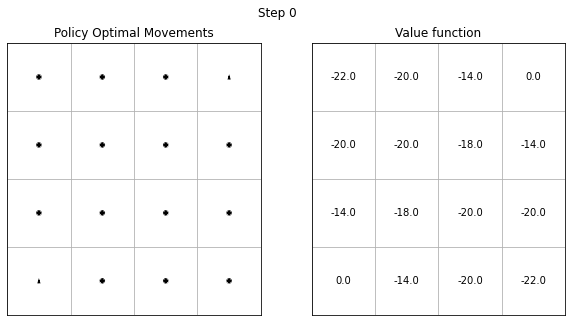

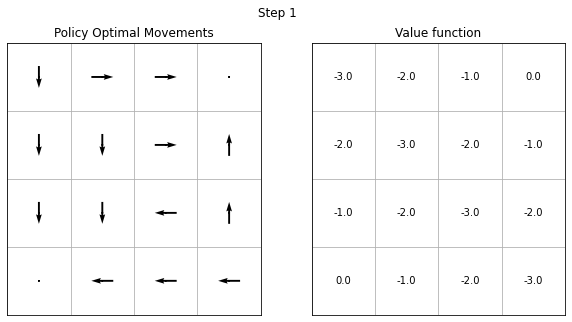

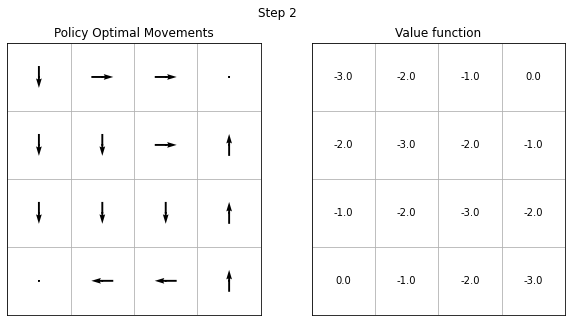

In [8]:
policy, v = policy_improvement(env)

In [9]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)